In [59]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### Import

In [71]:
df = pd.read_csv("data/SCFP2022.csv")
print("df shape:", df.shape)
df.head()

df shape: (22975, 357)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,3027.956120,2,70,5,9,3,2,2,...,4,2,4,2,1,8,3,3,2,1
1,1,12,3054.900065,2,70,5,9,3,2,2,...,4,2,5,2,1,8,3,3,2,1
2,1,13,3163.637766,2,70,5,9,3,2,2,...,4,2,4,2,1,8,3,3,1,1
3,1,14,3166.228463,2,70,5,9,3,2,2,...,3,2,4,1,1,6,3,2,1,1
4,1,15,3235.624715,2,70,5,9,3,2,2,...,3,2,4,2,1,8,3,3,1,1


### Explore

In [73]:
prop_biz_owners = len(df[df["HBUS"] == 1]) / len(df)
print("proportion of business owners in df:", prop_biz_owners)

proportion of business owners in df: 0.2779542981501632


In [74]:
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

df_inccat = df["INCCAT"].replace(inccat_dict).groupby(df["HBUS"]).value_counts(normalize=True).rename("frequency").to_frame().reset_index()

df_inccat

,HBUS,INCCAT,frequency
0,0,0-20,0.217373
1,0,21-39.9,0.202664
2,0,40-59.9,0.190186
3,0,60-79.9,0.173247
4,0,90-100,0.118995
5,0,80-89.9,0.097535
6,1,90-100,0.622142
7,1,60-79.9,0.103977
8,1,80-89.9,0.101159
9,1,40-59.9,0.062167


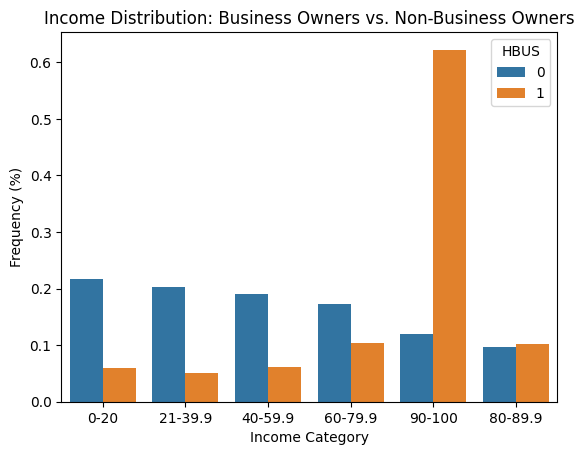

In [75]:
# Create bar chart of `df_inccat`
sns.barplot(x="INCCAT", y="frequency", hue="HBUS", data=df_inccat)
plt.xlabel("Income Category")
plt.ylabel("Frequency (%)")
plt.title("Income Distribution: Business Owners vs. Non-Business Owners");

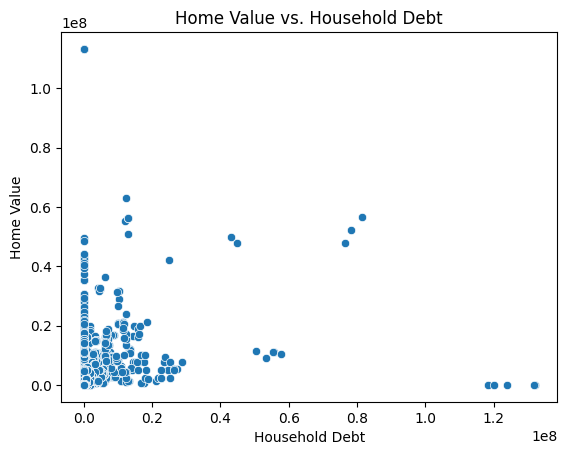

In [76]:
# Plot "HOUSES" vs "DEBT" with hue as business ownership
sns.scatterplot(data=df, x="DEBT", y="HOUSES")
plt.xlabel("Household Debt")
plt.ylabel("Home Value")
plt.title("Home Value vs. Household Debt");

In [77]:
mask = (df["HBUS"] == 1) & (df["INCOME"] < 500_000)
df_small_biz = df[mask]
print("df_small_biz shape:", df_small_biz.shape)
df_small_biz.head()

df_small_biz shape: (3320, 357)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,236.634754,1,46,3,12,4,2,0,...,4,5,5,5,2,8,9,9,4,4
6,2,22,245.848398,1,46,3,12,4,2,0,...,4,5,5,5,2,8,9,9,4,4
7,2,23,253.103477,1,46,3,12,4,2,0,...,4,5,5,5,2,8,9,9,4,4
8,2,24,252.908118,1,46,3,12,4,2,0,...,4,5,5,5,2,8,9,9,4,4
9,2,25,253.811312,1,46,3,12,4,2,0,...,4,5,5,5,2,8,9,9,4,4


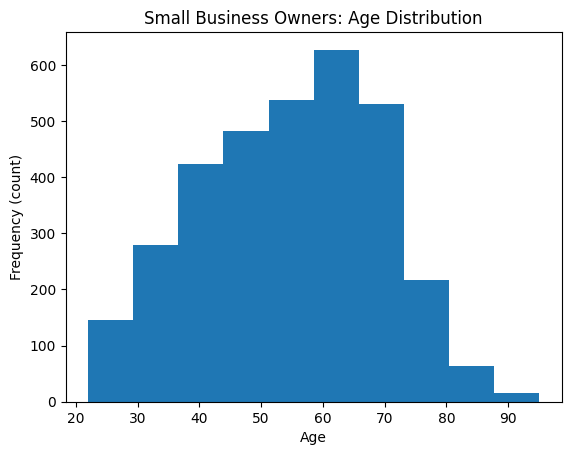

In [78]:
# Plot histogram of "AGE"
df_small_biz["AGE"].plot(kind="hist")
plt.xlabel("Age")
plt.ylabel("Frequency (count)")
plt.title("Small Business Owners: Age Distribution");

In [79]:
# Calculate variance, get 10 largest features
top_ten_var = df_small_biz.var().sort_values().tail(10)
top_ten_var

FIN          1.501234e+14
NONACTBUS    2.902772e+14
KGBUS        1.035592e+15
KGTOTAL      1.271725e+15
ACTBUS       1.586146e+15
BUS          2.429200e+15
NHNFIN       3.520996e+15
NFIN         3.554988e+15
NETWORTH     4.609543e+15
ASSET        4.702561e+15
dtype: float64

In [80]:
# Calculate trimmed variance
top_ten_trim_var = df_small_biz.apply(trimmed_var, limits=(0.1, 0.1)).sort_values().tail(10)
top_ten_trim_var

EQUITY      1.697384e+11
KGBUS       2.559997e+11
ACTBUS      5.958030e+11
FIN         6.117184e+11
BUS         6.804201e+11
KGTOTAL     9.095401e+11
NHNFIN      1.429019e+12
NFIN        2.475513e+12
NETWORTH    5.476571e+12
ASSET       6.017665e+12
dtype: float64

In [82]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    title="Small Business Owners: High Variance Features"
)
fig.update_layout(xaxis_title="Trimmed Variance [$]", yaxis_title="Feature")

fig.show()

In [83]:
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['KGTOTAL', 'NHNFIN', 'NFIN', 'NETWORTH', 'ASSET']

### Split

In [84]:
X = df_small_biz[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (3320, 5)


,KGTOTAL,NHNFIN,NFIN,NETWORTH,ASSET
5,164000.0,520000.0,1100000.0,721800.0,1240500.0
6,164000.0,520000.0,1100000.0,723800.0,1242500.0
7,164000.0,520000.0,1100000.0,721400.0,1241100.0
8,164000.0,520000.0,1100000.0,724300.0,1244000.0
9,164000.0,519000.0,1099000.0,722600.0,1241300.0


### Build Model

#### Iterate

In [85]:

n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    model.fit(X)
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    silhouette_scores.append(silhouette_score(X, model.named_steps["kmeans"].labels_))

print("Inertia:", inertia_errors[:11])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [2836.510206326178, 1354.7556694588739, 1221.3104959544232, 731.2761509209831, 459.01301231864824, 369.06947333883505, 205.2512664082038, 169.20999551064938, 153.218917667259, 129.91437091986697, 97.63142549699927]

Silhouette Scores: [np.float64(0.9871011969587334), np.float64(0.9845826757092052), np.float64(0.9831228638489724)]


In [87]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(x=n_clusters, y=inertia_errors, title="K-Means Model: Inertia vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")

fig.show()

In [88]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(x=n_clusters, y=silhouette_scores, title="K-Means Model: Silhouette Score vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Silhouette Score")

fig.show()

In [89]:
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=42))
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

### Communicate

In [90]:
labels = final_model.named_steps["kmeans"].labels_
xgb = X.groupby(labels).mean()
xgb

,KGTOTAL,NHNFIN,NFIN,NETWORTH,ASSET
0,2.241795e+06,2.821352e+06,3.549070e+06,4.837323e+06,5.134478e+06
1,5.750926e+08,9.562732e+08,9.604357e+08,1.060061e+09,1.075968e+09
2,2.661105e+08,5.053655e+08,5.081883e+08,6.012573e+08,6.013455e+08


In [92]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(xgb, barmode="group", title="Small Business Owner Finances by Cluster")
fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]")

fig.show()

In [93]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (3320, 2)


,PC1,PC2
0,-1.697837e+07,-529371.606945
1,-1.697631e+07,-529633.058207
2,-1.697826e+07,-529393.765566
3,-1.697527e+07,-529772.869896
4,-1.697844e+07,-529086.241349


In [95]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame=X_pca,
    x="PC1",
    y="PC2",
    color=labels.astype(str),
    title="PCA Representation of Clusters"
)
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")

fig.show()